In [1]:
import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy
import os, os.path

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb


import sys

In [2]:
data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/" + \
           "/01_NDVI_TS/no_ID/Grant/No_EVI/Grant_10_cloud/Grant_2016/"

param_dir = "/Users/hn/Documents/00_GitHub/Ag/remote_sensing/parameters/"


In [3]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')

In [4]:
import remote_sensing_core as rc
import remote_sensing_core as rcp

output_dir = data_dir
plot_dir_base = data_dir + "/plots/peaks_savitzky/"


In [5]:
file_names = ["Grant_2016_TS.csv"]
file_N = file_names[0]
a_df = pd.read_csv(data_dir + file_N)


In [6]:
a_df['CovrCrp'] = "NA" 
a_df['DataSrc'] = "NA" 

a_df = rc.initial_clean_NDVI(a_df)
a_df.head(2)
an_EE_TS = a_df.copy()

In [7]:
# a_df = a_df[a_df.CropTyp.isin(double_crop_potential_plants['Crop_Type'])]

polygon_list = an_EE_TS['geo'].unique()
print(len(polygon_list))


8169


In [8]:
max_output_columns = ['Acres', 'CovrCrp', 'CropGrp', 'CropTyp',
                      'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes',
                      'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'county', 'year', 'geo',
                      'max_Doy', 'max_value', 'max_count']

all_polygons_and_their_max_spline = pd.DataFrame(data=None, 
                                                 index=np.arange(3*len(an_EE_TS)), 
                                                 columns=max_output_columns)

all_polygons_and_their_max_savitzky = pd.DataFrame(data=None, 
                                                   index=np.arange(3*len(an_EE_TS)), 
                                                   columns=max_output_columns)


min_output_columns = ['Acres', 'CovrCrp', 'CropGrp', 'CropTyp',
                      'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes',
                      'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'county', 'year', 'geo',
                      'min_Doy', 'min_value', 'min_count']

all_polygons_and_their_min_spline = pd.DataFrame(data=None, 
                                                 index=np.arange(3*len(an_EE_TS)), 
                                                 columns=min_output_columns)

all_polygons_and_their_min_savitzky = pd.DataFrame(data=None, 
                                                   index=np.arange(3*len(an_EE_TS)), 
                                                   columns=min_output_columns)

# double_max_columns = ['Acres', 'CovrCrp', 'CropGrp', 'CropTyp',
#                       'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes',
#                       'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'county', 'year', 'geo',
#                       'max_count']

# double_poly_max_spline = pd.DataFrame(data=None, 
#                                       index=np.arange(2*len(an_EE_TS)), 
#                                       columns=double_max_columns)

# double_poly_max_savitzly = pd.DataFrame(data=None, 
#                                         index=np.arange(2*len(an_EE_TS)), 
#                                         columns=double_max_columns)


# double_min_columns = ['Acres', 'CovrCrp', 'CropGrp', 'CropTyp',
#                       'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes',
#                       'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'county', 'year', 'geo',
#                       'min_count']

# double_poly_min_spline = pd.DataFrame(data=None, 
#                                       index=np.arange(2*len(an_EE_TS)), 
#                                       columns=double_min_columns)

# double_poly_min_savitzly = pd.DataFrame(data=None, 
#                                         index=np.arange(2*len(an_EE_TS)), 
#                                         columns=double_min_columns)

pointer_max_spline = 0
pointer_min_spline = 0

pointer_max_savitzky = 0
pointer_min_savitzky = 0
counter = 0

In [78]:
a_poly = polygon_list[4]

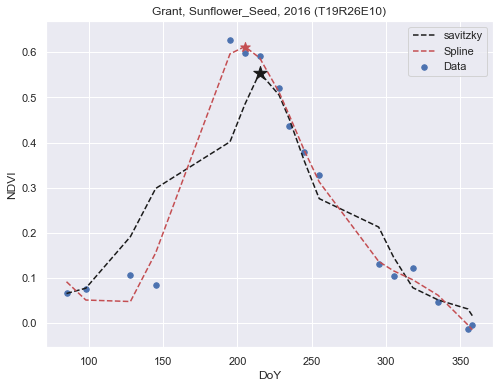

In [83]:
spline_max_df

,max_Doy,max_value,max_count
0,205.0,0.612696,1


In [84]:
WSDA_df = rc.keep_WSDA_columns(curr_field)
WSDA_df = WSDA_df.drop_duplicates()

In [89]:
pointer_min_savitzky

0

SystemError: <built-in method write of _io.BufferedWriter object at 0x7fa1906a54d0> returned a result with an error set

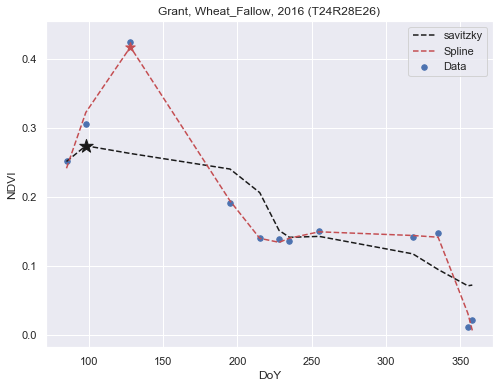

In [90]:
for a_poly in polygon_list:
    if (counter%1000 == 0):
        print (counter)
    counter += 1
    curr_field = an_EE_TS[an_EE_TS['geo']==a_poly]

    year = int(curr_field['year'].unique())
    plant = curr_field['CropTyp'].unique()[0]

    # Take care of names, replace "/" and "," and " " by "_"
    plant = plant.replace("/", "_")
    plant = plant.replace(",", "_")
    plant = plant.replace(" ", "_")
    plant = plant.replace("__", "_")

    county = curr_field['county'].unique()[0]
    TRS = curr_field['TRS'].unique()[0]

    ### 
    ###  There is a chance that a polygon is repeated twice?
    ###

    X = curr_field['doy']
    y = curr_field['NDVI']

    #############################################
    ###
    ###             Smoothen
    ###
    #############################################
    #
    #   Spline
    #

    x_basis = cr(X, df=7, constraints='center') # Generate spline basis with "freedom_df" degrees of freedom
    model = LinearRegression().fit(x_basis, y) # Fit model to the data
    spline_pred = model.predict(x_basis) # Get estimates

    #
    # savitzky
    #

    savitzky_pred = rc.savitzky_golay(y, window_size=5, order=1)

    #############################################
    ###
    ###             find peaks
    ###
    #############################################
    # 
    # Spline peaks
    # 
    spline_max_min = rc.my_peakdetect(y_axis=spline_pred, x_axis=X, delta=0.1);

    spline_max =  spline_max_min[0];
    spline_min =  spline_max_min[1];

    spline_max = rc.separate_x_and_y(m_list = spline_max);
    spline_min = rc.separate_x_and_y(m_list = spline_min);

    spline_max_DoYs_series = pd.Series(spline_max[0]);
    spline_max_series = pd.Series(spline_max[1]);

    spline_min_DoYs_series = pd.Series(spline_min[0]);
    spline_min_series = pd.Series(spline_min[1]);


    spline_max_df = pd.DataFrame({ 
                           'max_Doy': spline_max_DoYs_series,
                           'max_value': spline_max_series
                          })
    # add number of max to the data frame.
    spline_max_df['max_count'] = spline_max_df.shape[0]

    spline_min_df = pd.DataFrame({ 
                           'min_Doy': spline_min_DoYs_series,
                           'min_value': spline_min_series
                          })
    # add number of max to the data frame.
    spline_min_df['max_count'] = spline_min_df.shape[0]

    #################################################################################
    #
    #    savitzky
    #

    savitzky_max_min = rc.my_peakdetect(y_axis=savitzky_pred, x_axis=X, delta=0.1);

    savitzky_max =  savitzky_max_min[0];
    savitzky_min =  savitzky_max_min[1];

    savitzky_max = rc.separate_x_and_y(m_list = savitzky_max);
    savitzky_min = rc.separate_x_and_y(m_list = savitzky_min);

    savitzky_max_DoYs_series = pd.Series(savitzky_max[0]);
    savitzky_max_series = pd.Series(savitzky_max[1]);

    savitzky_min_DoYs_series = pd.Series(savitzky_min[0]);
    savitzky_min_series = pd.Series(savitzky_min[1]);


    savitzky_max_df = pd.DataFrame({ 
                           'max_Doy': savitzky_max_DoYs_series,
                           'max_value': savitzky_max_series
                          })
    # add number of max to the data frame.
    savitzky_max_df['max_count'] = savitzky_max_df.shape[0]

    savitzky_min_df = pd.DataFrame({ 
                           'min_Doy': savitzky_min_DoYs_series,
                           'min_value': savitzky_min_series
                          })
    # add number of max to the data frame.
    savitzky_min_df['max_count'] = savitzky_min_df.shape[0]
    ########################################################################################################
    ########################################################################################################

    #############################################
    ###
    ###             plot
    ###
    #############################################        
    sub_out = "/plant_based_plots/" + plant + "/"
    plot_path = plot_dir_base + sub_out
    plot_path = plot_path + str(spline_max_df.shape[0]) + "_peaks/"
    os.makedirs(plot_path, exist_ok=True)
    if (len(os.listdir(plot_path))<100):
        
        plot_title = county + ", " + plant + ", " + str(year) + " (" + TRS + ")"
        sb.set();

        fig, ax = plt.subplots(figsize=(8,6));
        ax.scatter(X, y, label="Data", s=30);

        ax.plot(X, savitzky_pred, 'k--', label="savitzky")
        ax.scatter(savitzky_max_DoYs_series, savitzky_max_series, s=200, c='k', marker='*');

        ax.plot(X, spline_pred, 'r--', label="Spline")
        ax.scatter(spline_max_DoYs_series, spline_max_series, s=100, c='r', marker='*');
        ax.legend(loc="best");

        ax.set_title(plot_title);
        ax.set(xlabel='DoY', ylabel='NDVI')
        ax.legend(loc="best");

        fig_name = plot_path + county + "_" + plant + "_" + str(year) + "_" + str(counter) + '.png'
        plt.savefig(fname = fig_name, \
                     dpi=300,
                     bbox_inches='tight')
        plt.close()
        del(plot_path, sub_out) #  county, plant, year

    if (len(spline_max_df)>0):
        WSDA_max_df_spline = pd.concat([WSDA_df]*spline_max_df.shape[0]).reset_index()
        # WSDA_max_df_spline = pd.concat([WSDA_max_df_spline, spline_max_df], axis=1, ignore_index=True)
        WSDA_max_df_spline = WSDA_max_df_spline.join(spline_max_df)
        if ("index" in WSDA_max_df_spline.columns):
            WSDA_max_df_spline = WSDA_max_df_spline.drop(columns=['index'])
        """
        copy the .values. Otherwise the index inconsistency between
        WSDA_max_df_spline and all_poly... will prevent the copying.
        """
        if (pointer_max_spline > all_polygons_and_their_max_spline.shape[0]):
            empty = pd.DataFrame(data=None, index=np.arange(500), columns=max_output_columns)
            all_polygons_and_their_max_spline = pd.concat([all_polygons_and_their_max_spline, empty]).reset_index()

        all_polygons_and_their_max_spline.iloc[pointer_max_spline:(pointer_max_spline + len(WSDA_max_df_spline))] = WSDA_max_df_spline.values
        pointer_max_spline += len(WSDA_max_df_spline)

    if (len(spline_min_df)>0):
        WSDA_min_df_spline = pd.concat([WSDA_df]*spline_min_df.shape[0]).reset_index()
        # WSDA_min_df_spline = pd.concat([WSDA_min_df_spline, spline_min_df], axis=1, ignore_index=True)
        WSDA_min_df_spline = WSDA_min_df_spline.join(spline_min_df)
        if ("index" in WSDA_min_df_spline.columns):
            WSDA_min_df_spline = WSDA_min_df_spline.drop(columns=['index'])
        """
        copy the .values. Otherwise the index inconsistency between
        WSDA_min_df_spline and all_poly... will prevent the copying.
        """
        if (pointer_min_spline > all_polygons_and_their_min_spline.shape[0]):
            empty = pd.DataFrame(data=None, index=np.arange(500), columns=min_output_columns)
            all_polygons_and_their_min_spline = pd.concat([all_polygons_and_their_min_spline, empty]).reset_index()

        all_polygons_and_their_min_spline.iloc[pointer_min_spline:(pointer_min_spline + len(WSDA_min_df_spline))] = WSDA_min_df_spline.values        
        pointer_min_spline += len(WSDA_min_df_spline)

    if (len(savitzky_max_df)>0):
        WSDA_max_df_savitzky = pd.concat([WSDA_df]*savitzky_max_df.shape[0]).reset_index()
        # WSDA_max_df_savitzky = pd.concat([WSDA_max_df_savitzky, savitzky_max_df], axis=1, ignore_index=True)
        WSDA_max_df_savitzky = WSDA_max_df_savitzky.join(savitzky_max_df)
        if ("index" in WSDA_max_df_savitzky.columns):
            WSDA_max_df_savitzky = WSDA_max_df_savitzky.drop(columns=['index'])
        """
        copy the .values. Otherwise the index inconsistency between
        WSDA_max_df_savitzky and all_poly... will prevent the copying.
        """
        if (pointer_max_savitzky > all_polygons_and_their_max_savitzky.shape[0]):
            empty = pd.DataFrame(data=None, index=np.arange(500), columns=min_output_columns)
            all_polygons_and_their_max_savitzky = pd.concat([all_polygons_and_their_max_savitzky, empty]).reset_index()

        all_polygons_and_their_max_savitzky.iloc[pointer_max_savitzky:(pointer_max_savitzky + len(WSDA_max_df_savitzky))] = WSDA_max_df_savitzky.values
        pointer_max_savitzky += len(WSDA_max_df_savitzky)



    if (len(savitzky_min_df)>0):
        WSDA_min_df_savitzky = pd.concat([WSDA_df]*savitzky_min_df.shape[0]).reset_index()
        # WSDA_min_df_savitzky = pd.concat([WSDA_min_df_savitzky, savitzky_min_df], axis=1, ignore_index=True)
        WSDA_min_df_savitzky = WSDA_min_df_savitzky.join(savitzky_min_df)
        if ("index" in WSDA_min_df_savitzky.columns):
            WSDA_min_df_savitzky = WSDA_min_df_savitzky.drop(columns=['index'])
        """
        copy the .values. Otherwise the index inconsistency between
        WSDA_min_df_savitzky and all_poly... will prevent the copying.
        """
        if (pointer_min_savitzky > all_polygons_and_their_min_savitzky.shape[0]):
            empty = pd.DataFrame(data=None, index=np.arange(500), columns=min_output_columns)
            all_polygons_and_their_min_savitzky = pd.concat([all_polygons_and_their_min_savitzky, empty]).reset_index()

        all_polygons_and_their_min_savitzky.iloc[pointer_min_savitzky:(pointer_min_savitzky + len(WSDA_min_df_savitzky))] = WSDA_min_df_savitzky.values
        pointer_min_savitzky += len(WSDA_min_df_savitzky)



In [ ]:
counter += 1
curr_field = an_EE_TS[an_EE_TS['geo']==a_poly]

year = int(curr_field['year'].unique())
plant = curr_field['CropTyp'].unique()[0]

# Take care of names, replace "/" and "," and " " by "_"
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = curr_field['county'].unique()[0]
TRS = curr_field['TRS'].unique()[0]

In [ ]:
X = curr_field['doy']
y = curr_field['NDVI']

# Smoothen

In [ ]:
###
###   Smoothen
###

#
#   Spline
#
# Generate spline basis with "freedom_df" degrees of freedom
x_basis = cr(X, df=7, constraints='center')

# Fit model to the data
model = LinearRegression().fit(x_basis, y)

# Get estimates
spline_pred = model.predict(x_basis)


#
# Savitzky
#
savitzky_pred = rc.savitzky_golay(y, window_size=5, order=1)

# Find peaks

In [ ]:
spline_max_min = rc.my_peakdetect(y_axis=spline_pred, x_axis=X, delta=0.1);

spline_max =  spline_max_min[0];
spline_min =  spline_max_min[1];

spline_max = rc.separate_x_and_y(m_list = spline_max);
spline_min = rc.separate_x_and_y(m_list = spline_min);

spline_max_DoYs_series = pd.Series(spline_max[0]);
spline_max_series = pd.Series(spline_max[1]);

spline_min_DoYs_series = pd.Series(spline_min[0]);
spline_min_series = pd.Series(spline_min[1]);


spline_max_df = pd.DataFrame({ 
                       'max_Doy': spline_max_DoYs_series,
                       'max_value': spline_max_series
                      })
# add number of max to the data frame.
spline_max_df['max_count'] = spline_max_df.shape[0]

spline_min_df = pd.DataFrame({ 
                       'max_Doy': spline_min_DoYs_series,
                       'max_value': spline_min_series
                      })
# add number of max to the data frame.
spline_min_df['max_count'] = spline_min_df.shape[0]

#################################################################################
#
#    Savitzky
#

savitzky_max_min = rc.my_peakdetect(y_axis=savitzky_pred, x_axis=X, delta=0.1);

savitzky_max =  savitzky_max_min[0];
savitzky_min =  savitzky_max_min[1];

savitzky_max = rc.separate_x_and_y(m_list = savitzky_max);
savitzky_min = rc.separate_x_and_y(m_list = savitzky_min);

savitzky_max_DoYs_series = pd.Series(savitzky_max[0]);
savitzky_max_series = pd.Series(savitzky_max[1]);

savitzky_min_DoYs_series = pd.Series(savitzky_min[0]);
savitzky_min_series = pd.Series(savitzky_min[1]);


savitzky_max_df = pd.DataFrame({ 
                       'max_Doy': savitzky_max_DoYs_series,
                       'max_value': savitzky_max_series
                      })
# add number of max to the data frame.
savitzky_max_df['max_count'] = savitzky_max_df.shape[0]

savitzky_min_df = pd.DataFrame({ 
                       'max_Doy': savitzky_min_DoYs_series,
                       'max_value': savitzky_min_series
                      })
# add number of max to the data frame.
savitzky_min_df['max_count'] = savitzky_min_df.shape[0]

In [ ]:
plot_title = county + ", " + plant + ", " + str(year) + " (" + TRS + ")"
sb.set();

fig, ax = plt.subplots(figsize=(8,6));
ax.scatter(X, y, label="Data", s=30);

ax.plot(X, savitzky_pred, 'k--', label="Savitzky")
ax.scatter(savitzky_max_DoYs_series, savitzky_max_series, s=200, c='k', marker='*');

ax.plot(X, spline_pred, 'r--', label="Spline")
ax.scatter(spline_max_DoYs_series, spline_max_series, s=100, c='r', marker='*');
ax.legend(loc="best");

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='NDVI')
ax.legend(loc="best");


In [ ]:
# add number of peaks to the data frame.
spline_max_df['max_count'] = spline_max_df.shape[0]

WSDA_max_df_spline = rc.keep_WSDA_columns(curr_field)
WSDA_max_df_spline = WSDA_max_df_spline.drop_duplicates()

if (len(spline_max_df)>0):
    WSDA_max_df_spline = pd.concat([WSDA_max_df_spline]*spline_max_df.shape[0]).reset_index()
    # WSDA_max_df_spline = pd.concat([WSDA_max_df_spline, spline_max_df], axis=1, ignore_index=True)
    WSDA_max_df_spline = WSDA_max_df_spline.join(spline_max_df)
    if ("index" in WSDA_max_df_spline.columns):
        WSDA_max_df_spline = WSDA_max_df_spline.drop(columns=['index'])
    """
    copy the .values. Otherwise the index inconsistency between
    WSDA_max_df_spline and all_poly... will prevent the copying.
    """
    all_polygons_and_their_max_spline.iloc[pointer_max_spline:(pointer_max_spline + len(WSDA_max_df_spline))] = WSDA_max_df_spline.values

    pointer_max_spline += len(WSDA_max_df_spline)

if (len(spline_min_df)>0):
    WSDA_min_df_spline = pd.concat([WSDA_min_df_spline]*spline_min_df.shape[0]).reset_index()
    # WSDA_min_df_spline = pd.concat([WSDA_min_df_spline, spline_min_df], axis=1, ignore_index=True)
    WSDA_min_df_spline = WSDA_min_df_spline.join(spline_min_df)
    if ("index" in WSDA_min_df_spline.columns):
        WSDA_min_df_spline = WSDA_min_df_spline.drop(columns=['index'])
    """
    copy the .values. Otherwise the index inconsistency between
    WSDA_min_df_spline and all_poly... will prevent the copying.
    """
    all_polygons_and_their_min_spline.iloc[pointer_min_spline:(pointer_min_spline + len(WSDA_min_df_spline))] = WSDA_min_df_spline.values

    pointer_min_spline += len(WSDA_min_df_spline)


# add number of peaks to the data frame.
savitzky_max_df['max_count'] = savitzky_max_df.shape[0]

WSDA_max_df_savitzky = rc.keep_WSDA_columns(curr_field)
WSDA_max_df_savitzky = WSDA_max_df_savitzky.drop_duplicates()

if (len(savitzky_max_df)>0):
    WSDA_max_df_savitzky = pd.concat([WSDA_max_df_savitzky]*savitzky_max_df.shape[0]).reset_index()
    # WSDA_max_df_savitzky = pd.concat([WSDA_max_df_savitzky, savitzky_max_df], axis=1, ignore_index=True)
    WSDA_max_df_savitzky = WSDA_max_df_savitzky.join(savitzky_max_df)
    if ("index" in WSDA_max_df_savitzky.columns):
        WSDA_max_df_savitzky = WSDA_max_df_savitzky.drop(columns=['index'])
    """
    copy the .values. Otherwise the index inconsistency between
    WSDA_max_df_savitzky and all_poly... will prevent the copying.
    """
    all_polygons_and_their_max_savitzky.iloc[pointer_max_savitzky:(pointer_max_savitzky + len(WSDA_max_df_savitzky))] = WSDA_max_df_savitzky.values

    pointer_max_savitzky += len(WSDA_max_df_savitzky)

if (len(savitzky_min_df)>0):
    WSDA_min_df_savitzky = pd.concat([WSDA_min_df_savitzky]*savitzky_min_df.shape[0]).reset_index()
    # WSDA_min_df_savitzky = pd.concat([WSDA_min_df_savitzky, savitzky_min_df], axis=1, ignore_index=True)
    WSDA_min_df_savitzky = WSDA_min_df_savitzky.join(savitzky_min_df)
    if ("index" in WSDA_min_df_savitzky.columns):
        WSDA_min_df_savitzky = WSDA_min_df_savitzky.drop(columns=['index'])
    """
    copy the .values. Otherwise the index inconsistency between
    WSDA_min_df_savitzky and all_poly... will prevent the copying.
    """
    all_polygons_and_their_min_savitzky.iloc[pointer:(pointer_min_savitzky + len(pointer_min_savitzky))] = WSDA_min_df_savitzky.values

    pointer_min_savitzky += len(WSDA_min_df_savitzky)



In [ ]:
all_polygons_and_their_max_spline.iloc[0,:]

In [ ]:
all_polygons_and_their_max_savitzky.iloc[0,:]

In [ ]:
A = pd.concat([double_polygons, pd.DataFrame(data=None, 
                                index=np.arange(2*len(an_EE_TS)), 
                                columns=double_columns)] )